In [1]:
import os, sys
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.interpolate import make_interp_spline

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from forecasting.get_forecasting_model import *

In [2]:
processed_dir = os.path.join(project_root, "data", "processed")

# Load data
df = pd.read_csv(os.path.join(processed_dir, "train.csv"))
viz = pd.read_csv(os.path.join(processed_dir, "for_visualization.csv"))

df['time'] = pd.to_datetime(df['time'])
viz['time'] = pd.to_datetime(viz['time'])

df['status'] = df['status'].astype(str)

In [3]:
predictor5 = Predictor('rvfl', '5min')
predictor1 = Predictor('rvfl', '1min')
predictor15 = Predictor('rvfl', '15min')
predictor60 = Predictor('rvfl', '60min')

df_agg_5 = predictor5.agg_df(df)
df_agg_1 = predictor1.agg_df(df)
df_agg_15 = predictor15.agg_df(df)
df_agg_60 = predictor60.agg_df(df)

In [4]:
df.head(1)

,ip,identd,user,time,request,status,size,resource,protocol,utc,status_label
0,199.72.81.55,-,-,1995-07-01 00:00:01,GET /history/apollo/ HTTP/1.0,200,6245.0,/history/apollo/,HTTP/1.0,UTC - 04,Success


In [6]:
df_agg_5.head(1)

,time,size,Error,No Change,Not Found,Redirected,Success,anomaly,log_time
0,1995-07-01,5277675.0,0.0,19.0,1.0,14.0,267.0,False,15.478996


### 1. Overall

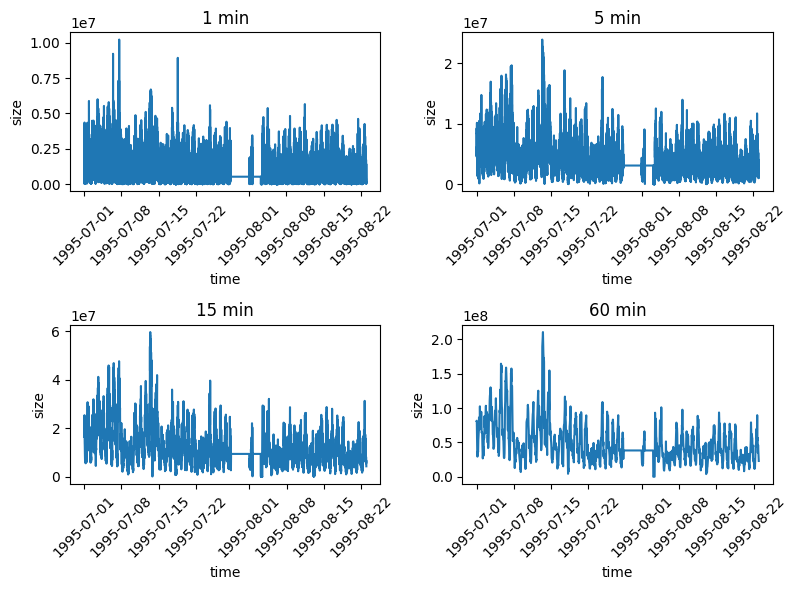

In [4]:
plt.figure(figsize = (8,6))

plt.subplot(2,2,1)
sns.lineplot(data=df_agg_1, x='time', y='size')
plt.title('1 min')
plt.xticks(rotation = 45)

plt.subplot(2,2,2)
sns.lineplot(data=df_agg_5, x='time', y='size')
plt.title('5 min')
plt.xticks(rotation = 45)

plt.subplot(2,2,3)
sns.lineplot(data=df_agg_15, x='time', y='size')
plt.title('15 min')
plt.xticks(rotation = 45)

plt.subplot(2,2,4)
sns.lineplot(data=df_agg_60, x='time', y='size')
plt.title('60 min')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

In [5]:
def resample_and_spike(df, freq, threshold=3):
    """
    Resamples hits by sum and error_rate by mean.
    Recalculates spikes using Z-Score of the new aggregated hits.
    """
    resampled = df.set_index('time').resample(freq).agg({
        'hits_per_sec': 'sum',
        'error_rate': 'mean'
    }).reset_index()
    
    resampled['z_score'] = stats.zscore(resampled['hits_per_sec'])
    resampled['is_spike'] = resampled['z_score'].abs() > threshold
    
    return resampled

viz_1m = resample_and_spike(viz, '1min')
viz_5m = resample_and_spike(viz, '5min')
viz_15m = resample_and_spike(viz, '15min')

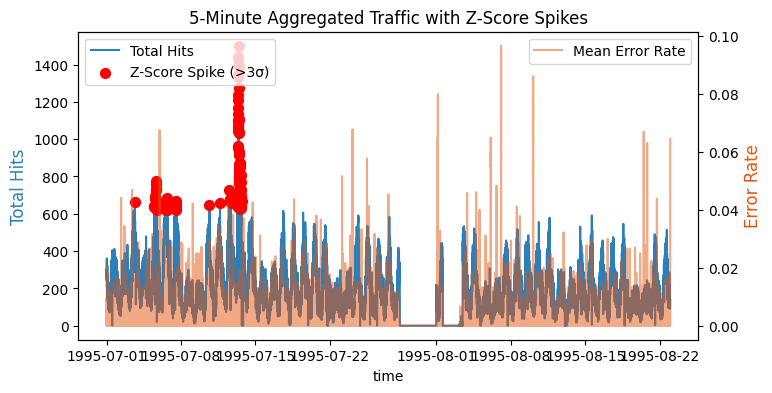

In [6]:
def plot_resampled_viz(df, title="Traffic Analysis"):
    plt.figure(figsize=(8, 4))
    ax1 = plt.gca()
    
    # Hits (Sum)
    sns.lineplot(data=df, x='time', y='hits_per_sec', ax=ax1, color='#2c7fb8', label='Total Hits')
    ax1.set_ylabel('Total Hits', color='#2c7fb8', fontsize=12)
    
    # Error Rate (Mean)
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x='time', y='error_rate', ax=ax2, color='#e6550d', label='Mean Error Rate', alpha=0.5)
    ax2.set_ylabel('Error Rate', color='#e6550d', fontsize=12)
    ax2.grid(False)
    
    # Z-Score Spikes
    spikes = df[df['is_spike']]
    if not spikes.empty:
        ax1.scatter(spikes['time'], spikes['hits_per_sec'], color='red', s=50, zorder=5, label='Z-Score Spike (>3σ)')
    
    plt.title(title)
    ax1.legend(loc='upper left')
    plt.show()

plot_resampled_viz(viz_5m, "5-Minute Aggregated Traffic with Z-Score Spikes")

### Detailed

In [9]:
df.columns

Index(['ip', 'identd', 'user', 'time', 'request', 'status', 'size', 'resource',
       'protocol', 'utc', 'status_label'],
      dtype='object')

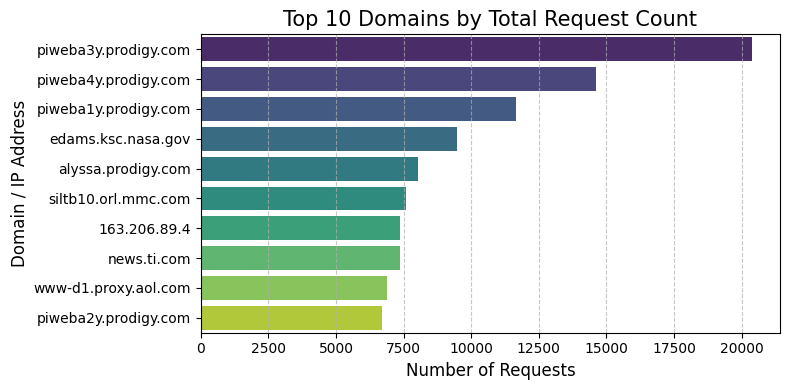

In [10]:
top_domains = df['ip'].value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(
    x=top_domains.values, 
    y=top_domains.index, 
    palette='viridis',
    hue=top_domains.index,
    legend=False
)

plt.title('Top 10 Domains by Total Request Count', fontsize=15)
plt.xlabel('Number of Requests', fontsize=12)
plt.ylabel('Domain / IP Address', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

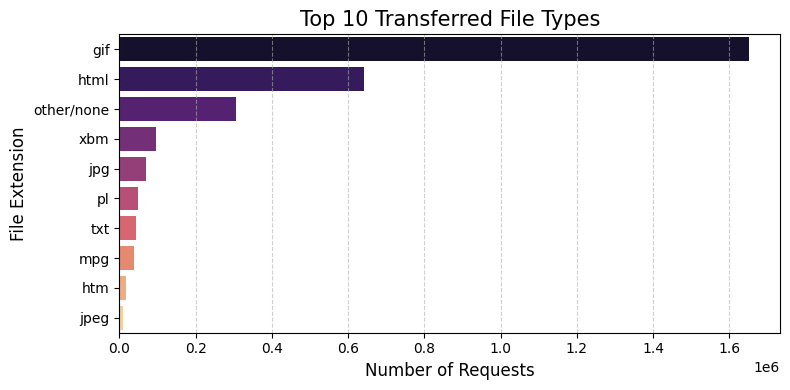

In [11]:
df['file_type'] = df['resource'].str.extract(r'\.([a-z0-9]{2,4})$', expand=False).str.lower()

top_file_types = df['file_type'].fillna('other/none').value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(
    x=top_file_types.values, 
    y=top_file_types.index, 
    palette='magma',
    hue=top_file_types.index,
    legend=False
)

plt.title('Top 10 Transferred File Types', fontsize=15)
plt.xlabel('Number of Requests', fontsize=12)
plt.ylabel('File Extension', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

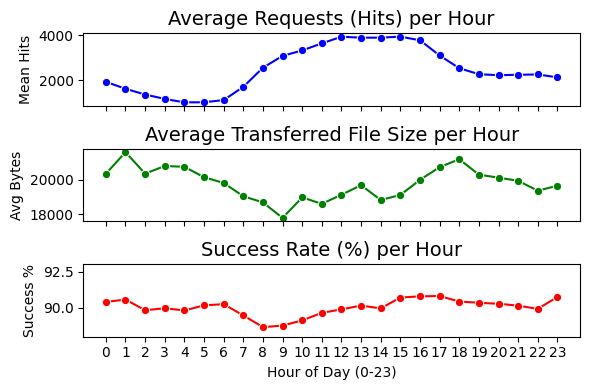

In [12]:
df['hour'] = df['time'].dt.hour
num_days = df['time'].dt.date.nunique()

daily_metrics = df.groupby('hour').agg(
    total_hits=('time', 'count'),
    mean_file_size=('size', 'mean'),
    success_count=('status_label', lambda x: (x == 'Success').sum())
).reset_index()

daily_metrics['mean_hits'] = daily_metrics['total_hits'] / num_days
daily_metrics['success_rate_%'] = (daily_metrics['success_count'] / daily_metrics['total_hits']) * 100

fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=True)

sns.lineplot(data=daily_metrics, x='hour', y='mean_hits', ax=axes[0], marker='o', color='blue')
axes[0].set_title('Average Requests (Hits) per Hour', fontsize=14)
axes[0].set_ylabel('Mean Hits')

sns.lineplot(data=daily_metrics, x='hour', y='mean_file_size', ax=axes[1], marker='o', color='green')
axes[1].set_title('Average Transferred File Size per Hour', fontsize=14)
axes[1].set_ylabel('Avg Bytes')

sns.lineplot(data=daily_metrics, x='hour', y='success_rate_%', ax=axes[2], marker='o', color='red')
axes[2].set_title('Success Rate (%) per Hour', fontsize=14)
axes[2].set_ylabel('Success %')
axes[2].set_ylim(88, 93) # Success is usually high, zoom in to see fluctuations

plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0-23)')
plt.tight_layout()
plt.show()

In [13]:
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

from plot_utils import plot_weekly_heatmap
from plot_utils import plot_weekly_patterns
from plot_utils import plot_daily_profile
# from plot_utils import plot_daily_profile_split
from plot_utils import analyze_status_distribution
from plot_utils import plot_file_type_stats
from plot_utils import plot_status_breakdown
from plot_utils import plot_rolling_statistics
from plot_utils import plot_anomaly_spikes
from plot_utils import plot_status_evolution
from plot_utils import plot_size_distribution



d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:70: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = df.resample(interval).size()


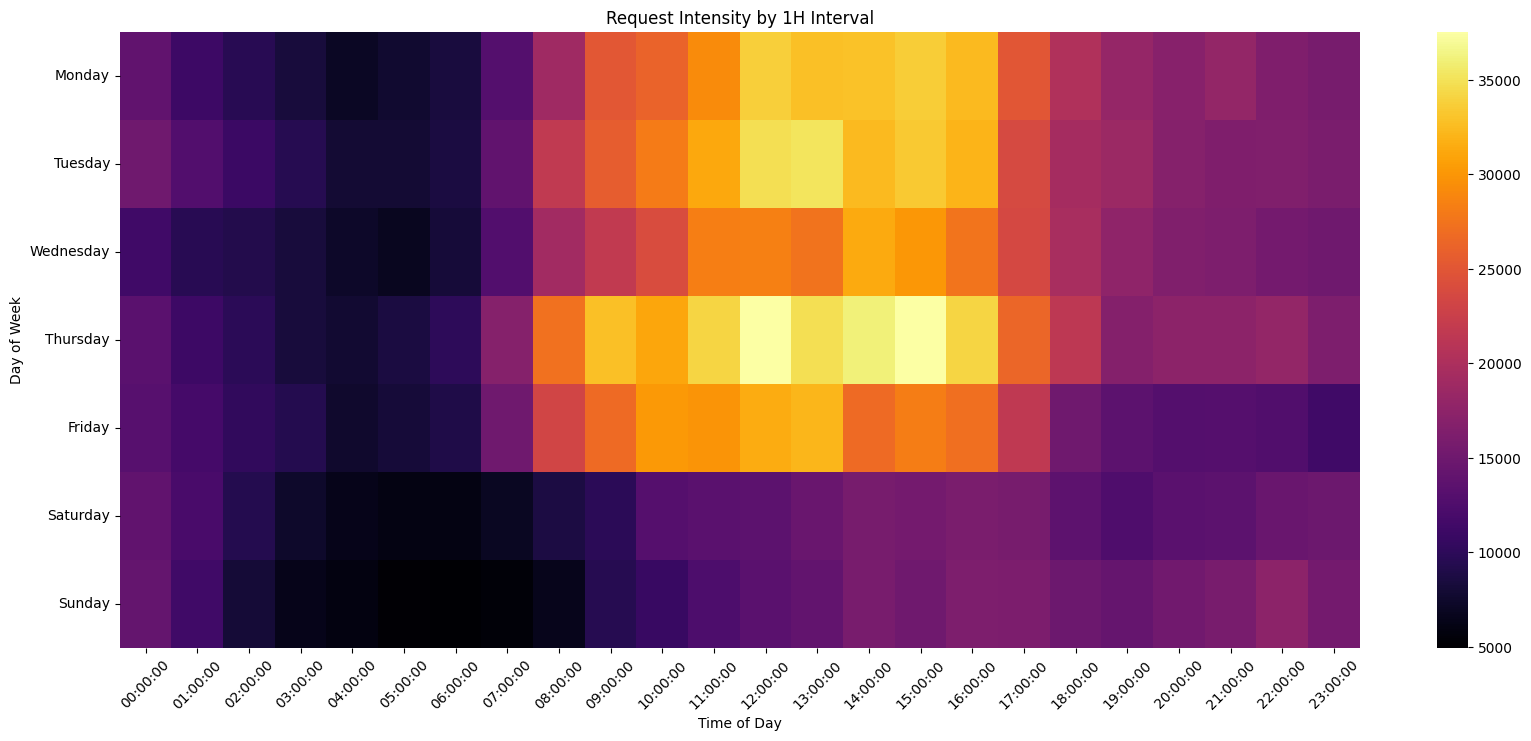

In [14]:
plot_weekly_heatmap(df, '1H')

Processing data for 15T patterns...


d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:197: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = df.resample(interval)
d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:209: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts_success = df[df['status_label'] == 'Success'].resample(interval).size()


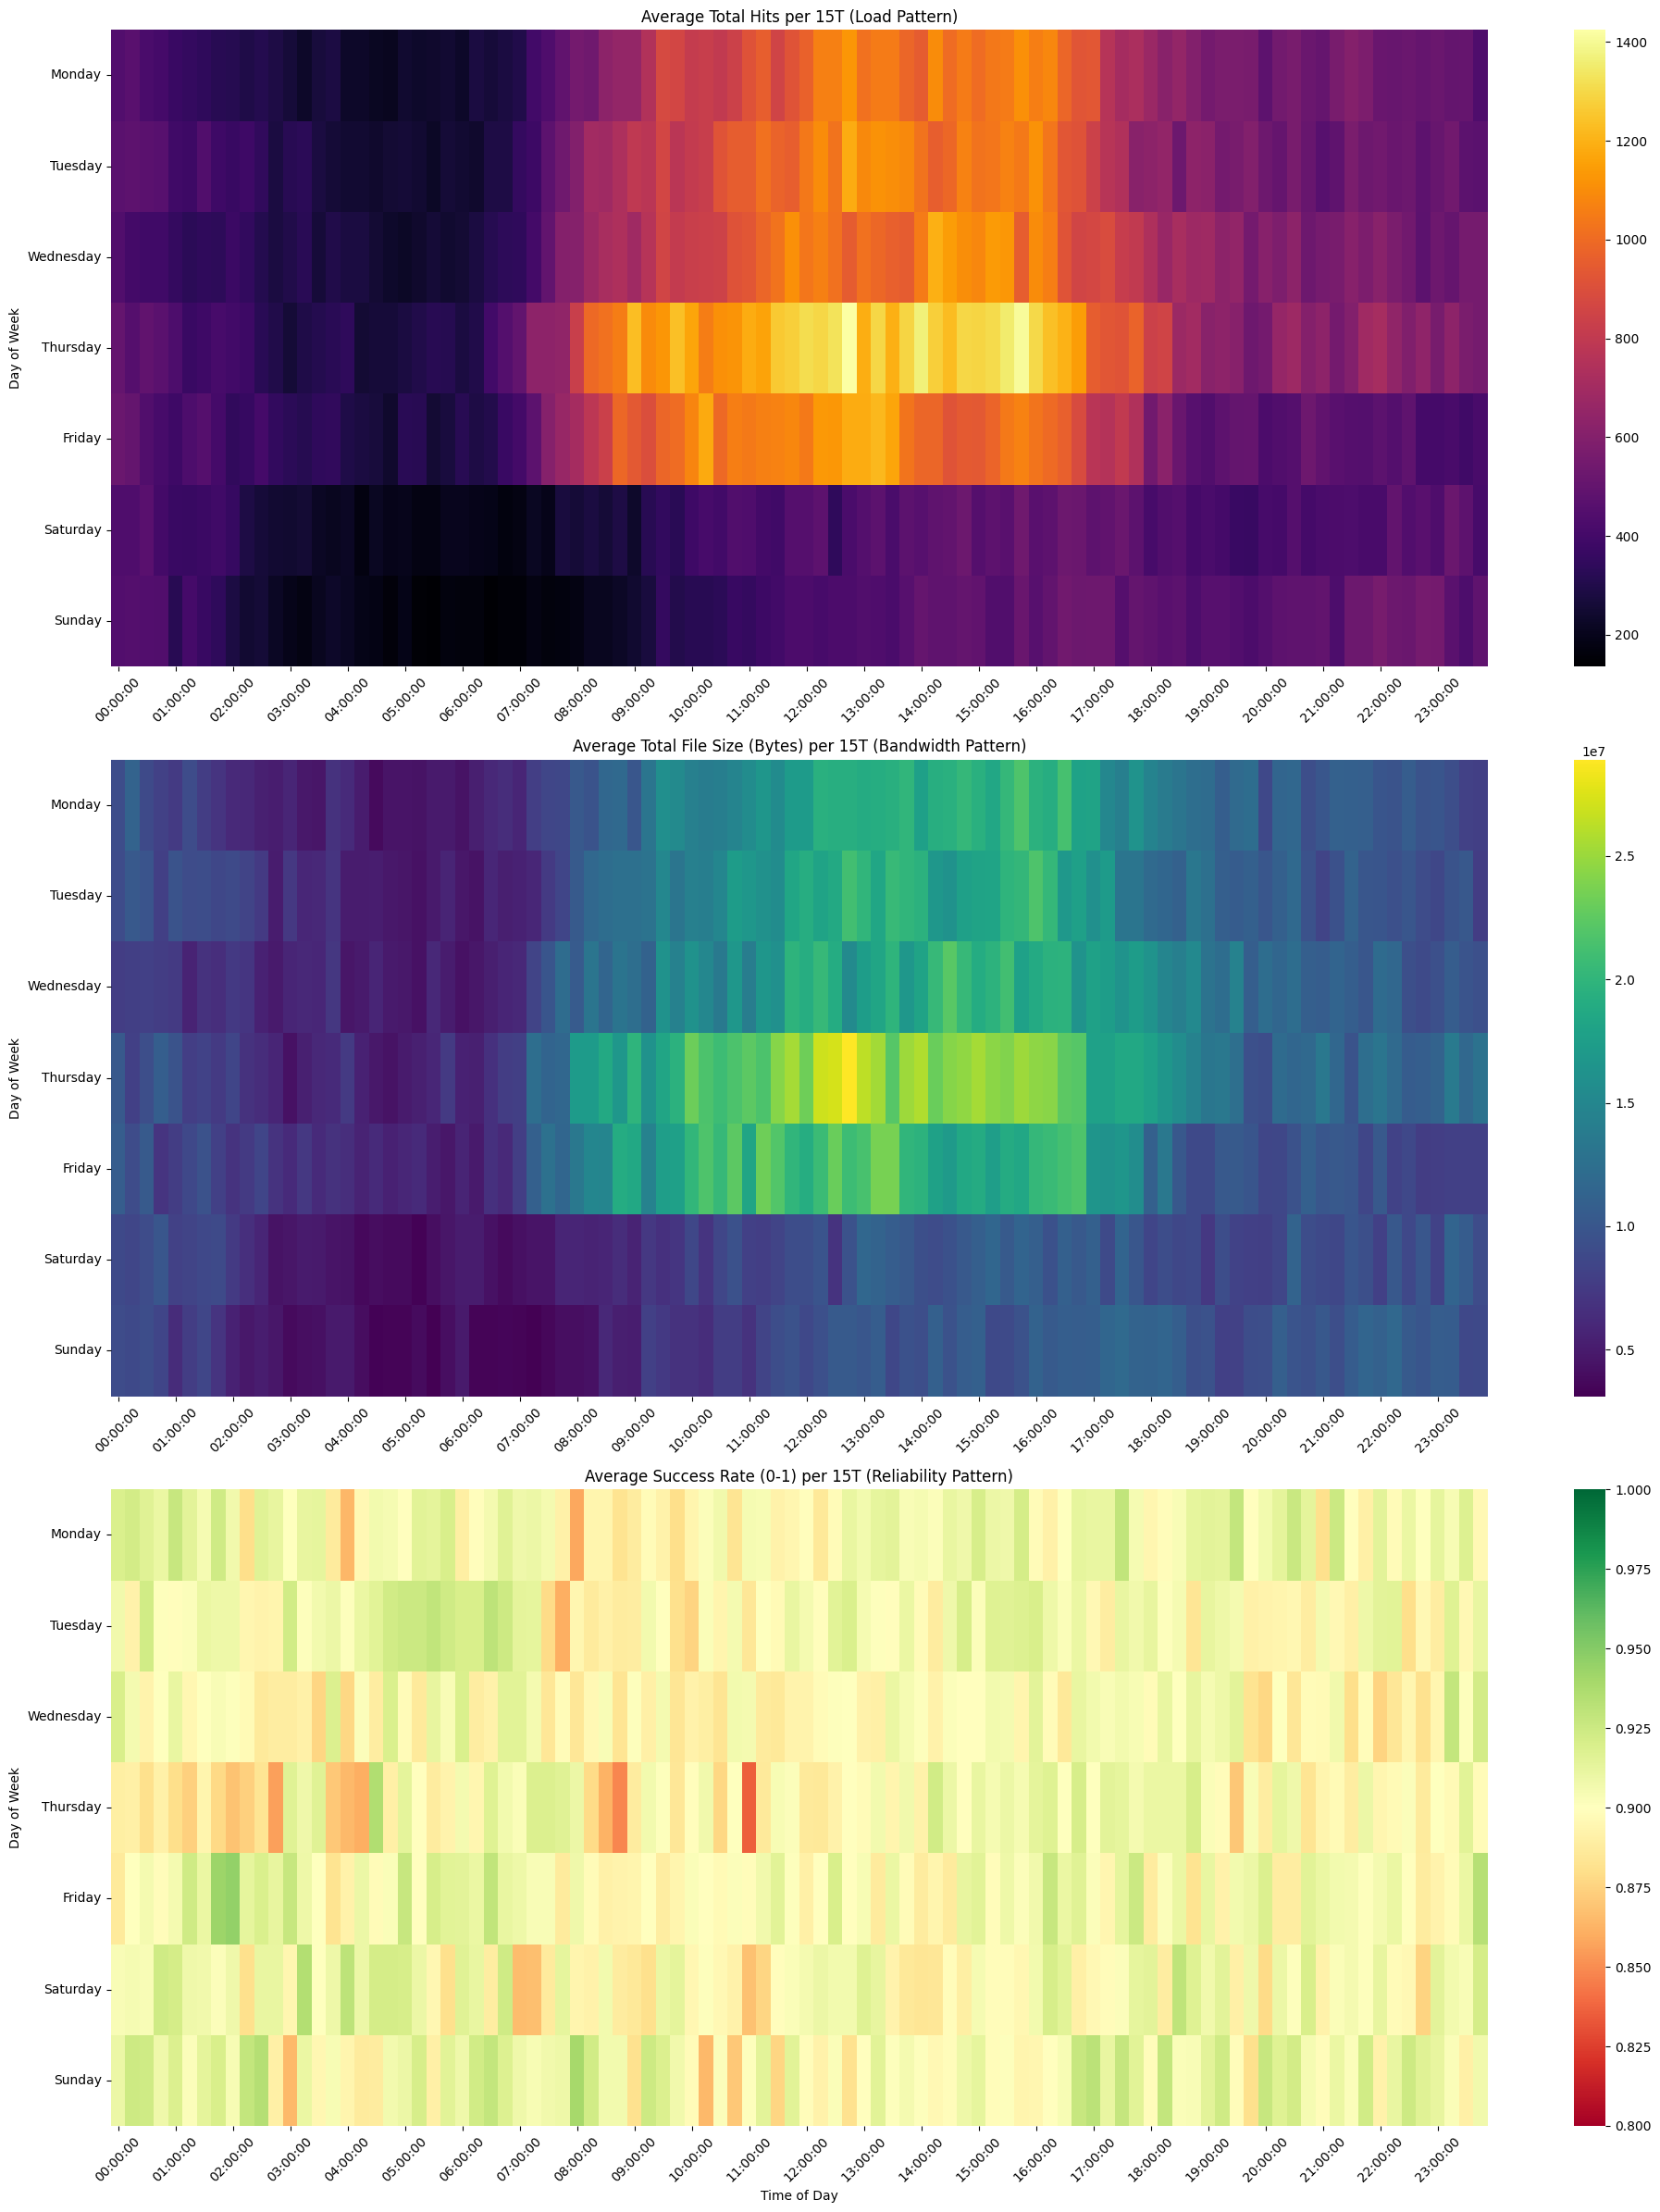

In [ ]:
plot_weekly_patterns(df, interval='15T', figsize=(20, 24))

Generating daily profile (Time of Day analysis) for 10T interval...


d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:283: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = df.resample(interval)
d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:291: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts_success = df[df['status_label'] == 'Success'].resample(interval).size()


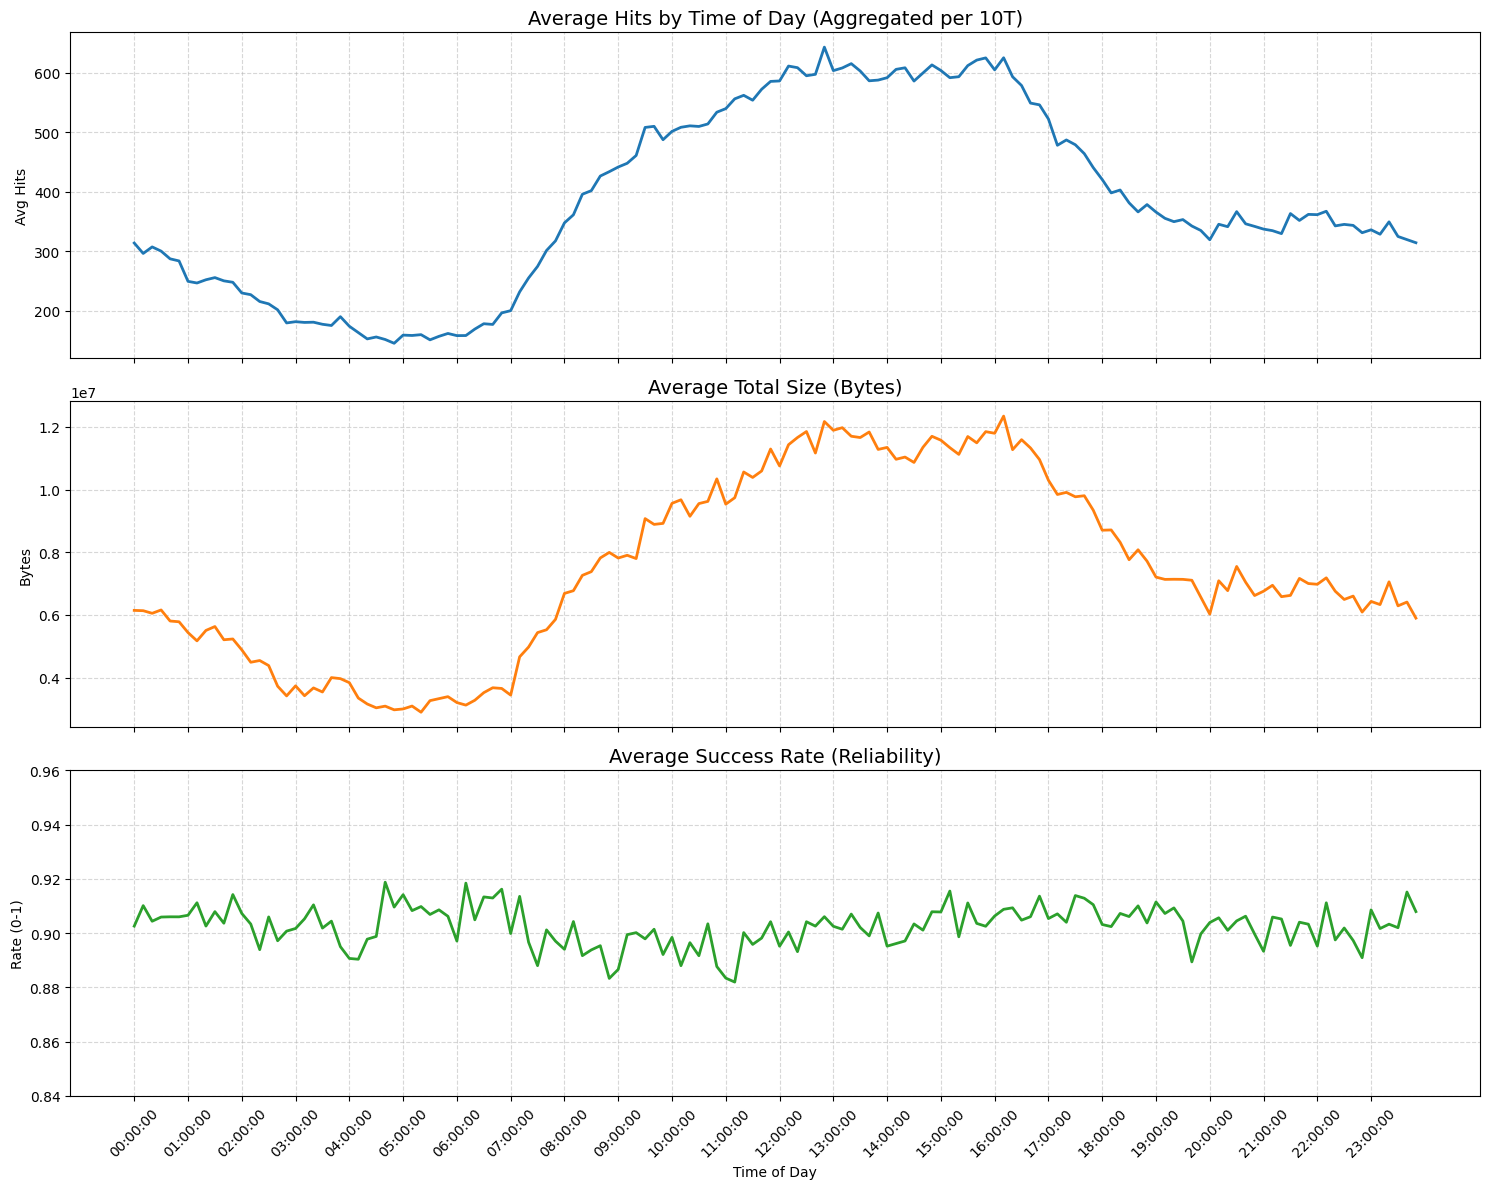

In [16]:
plot_daily_profile(df, interval='10T')

In [ ]:
# fig_hits, fig_size, fig_rate= plot_daily_profile_split(df, interval='10T')


Analyzing Status Distribution for 5T Interval...


d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:118: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  status_counts = df.groupby([pd.Grouper(freq=interval), col]).size().unstack(fill_value=0)


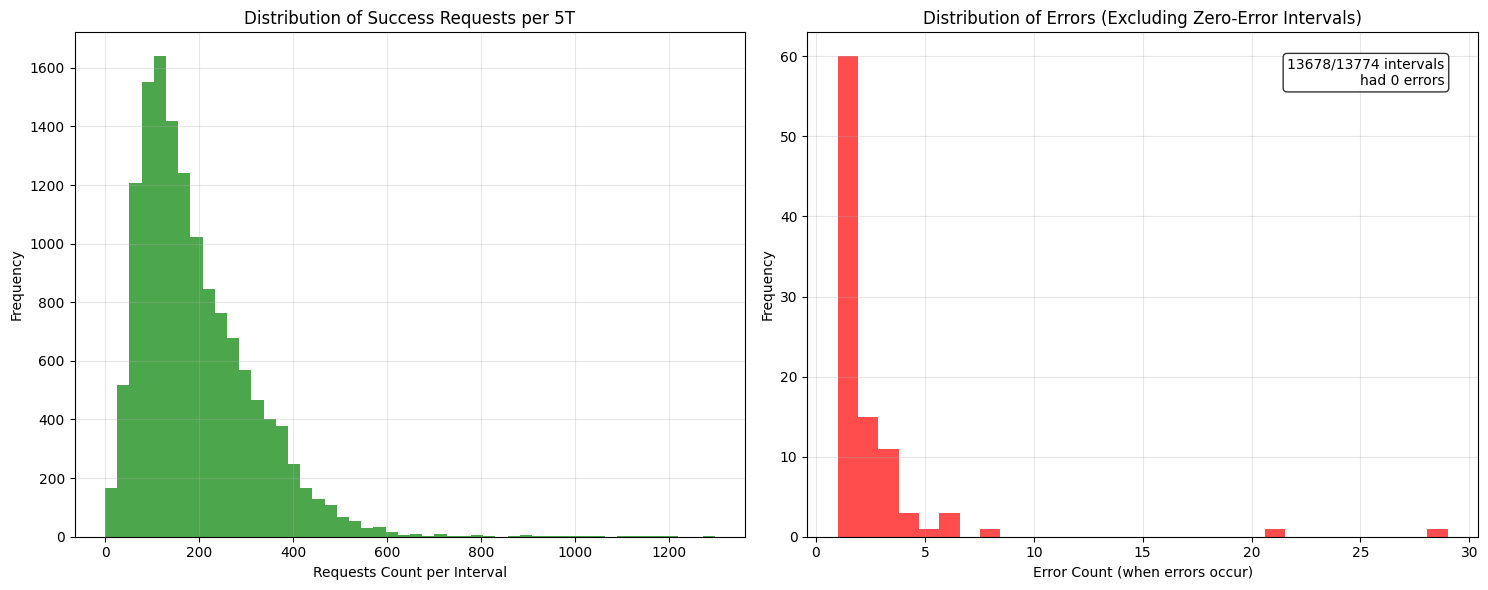

Stats for 5T:


status_label,Success,Error
count,13774.000000,13774.000000
mean,191.840497,0.015682
std,120.199392,0.355702
min,0.000000,0.000000
25%,104.000000,0.000000
50%,163.000000,0.000000
75%,258.000000,0.000000
max,1298.000000,29.000000


In [17]:
analyze_status_distribution(df)

Analyzing File Types...


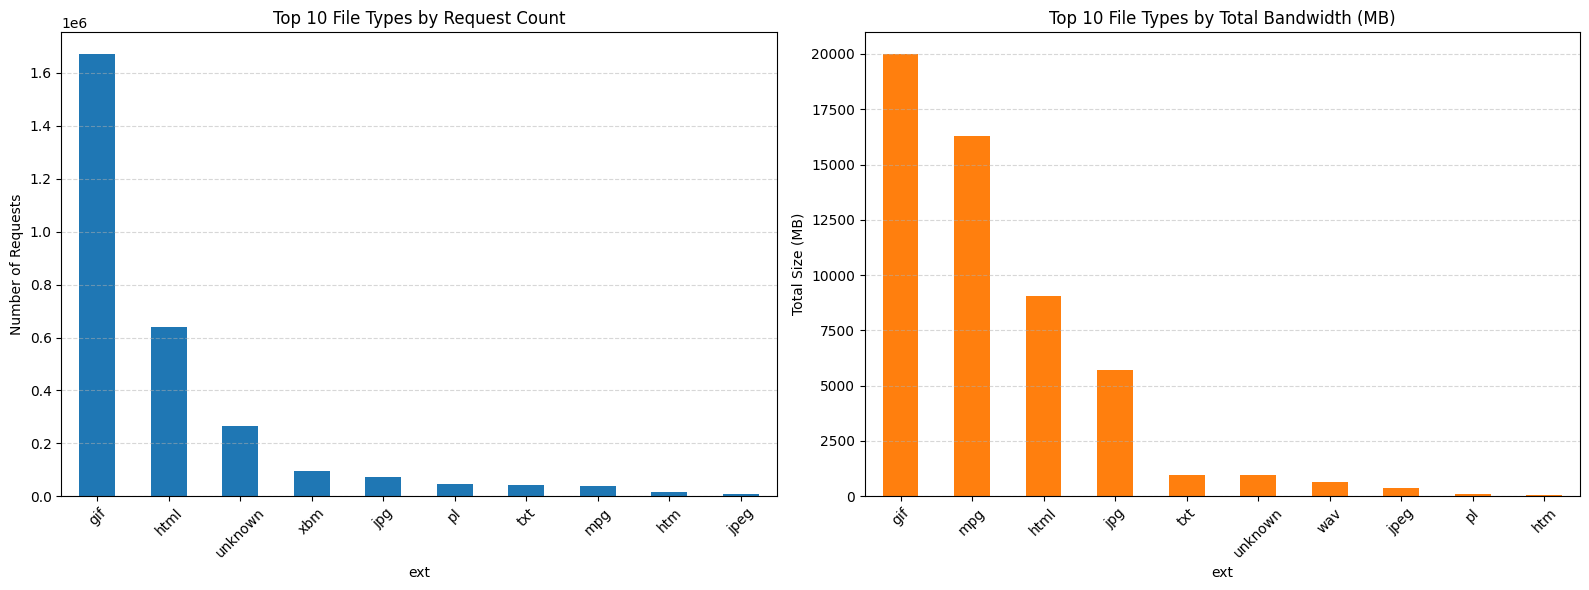

In [18]:
plot_file_type_stats(df)

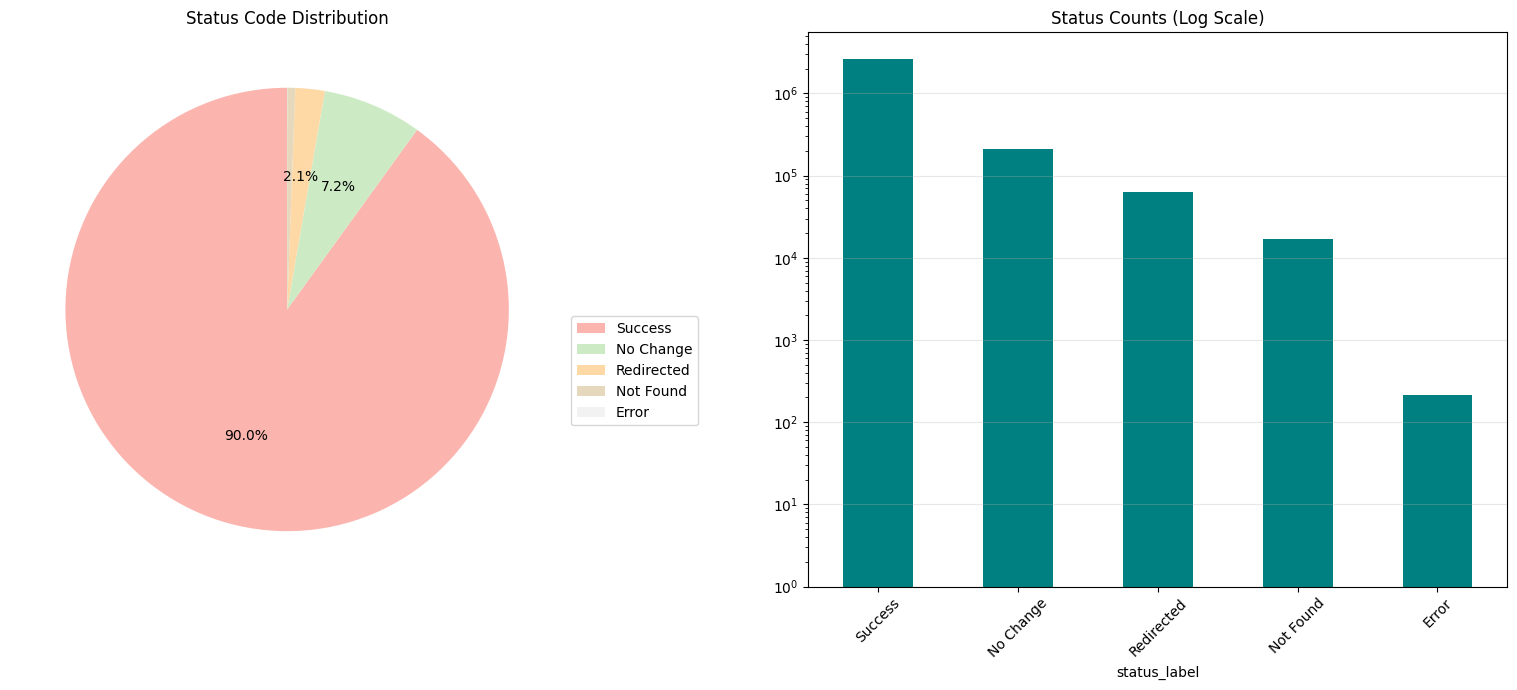

In [19]:
plot_status_breakdown(df)


Calculating Rolling Statistics (window=1H)...


d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:480: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts = df.resample('10T').size().fillna(0) # Base resolution 10 mins for better rolling smoothness
d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:485: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  roller = ts.rolling(window=window)


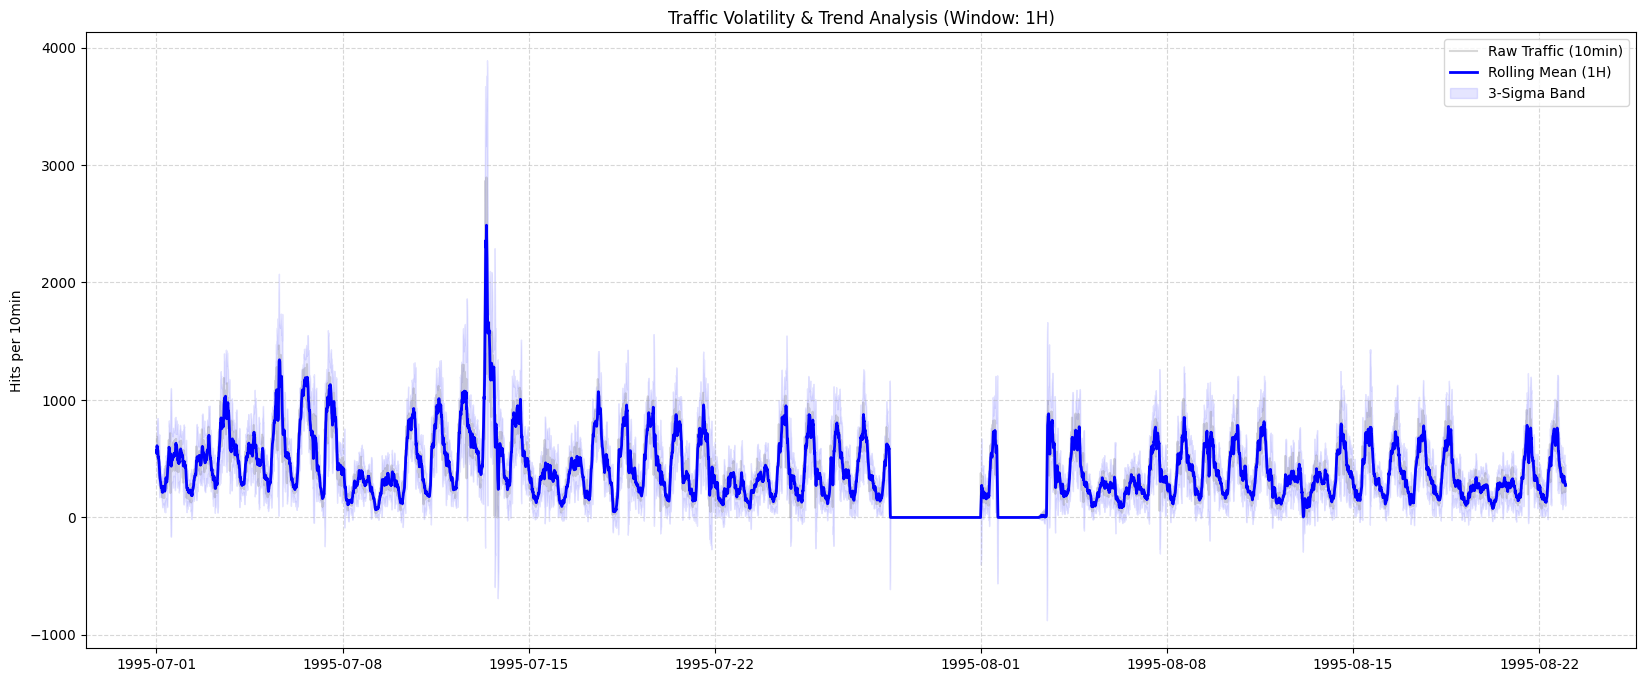

In [20]:
plot_rolling_statistics(df, window='1H')


Detecting Anomalies (Interval: 1T, Z-Threshold: 3)...


d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:528: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = df.resample(interval)
d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:538: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts_success = df[df['status_label'] == 'Success'].resample(interval).size()



Top Anomalies for Traffic Volume (Hits):


,Hits
time,
1995-07-13 09:49:00,405
1995-07-13 09:34:00,342
1995-07-13 09:13:00,337
1995-07-13 09:00:00,334
1995-07-13 09:08:00,332



Top Anomalies for Total Bandwidth (Bytes):


,Bytes
time,
1995-07-07 14:03:00,"10,214,823"
1995-07-06 10:19:00,"9,211,707"
1995-07-18 14:05:00,"8,925,150"
1995-07-07 13:37:00,"7,306,435"
1995-07-07 10:28:00,"7,305,970"



Top Anomalies for Success Rate:


,Rate (0-1)
time,
1995-08-22 06:28:00,0.0000
1995-07-21 18:55:00,0.0000
1995-08-03 11:20:00,0.0000
1995-08-19 19:52:00,0.0000
1995-08-20 06:07:00,0.0000


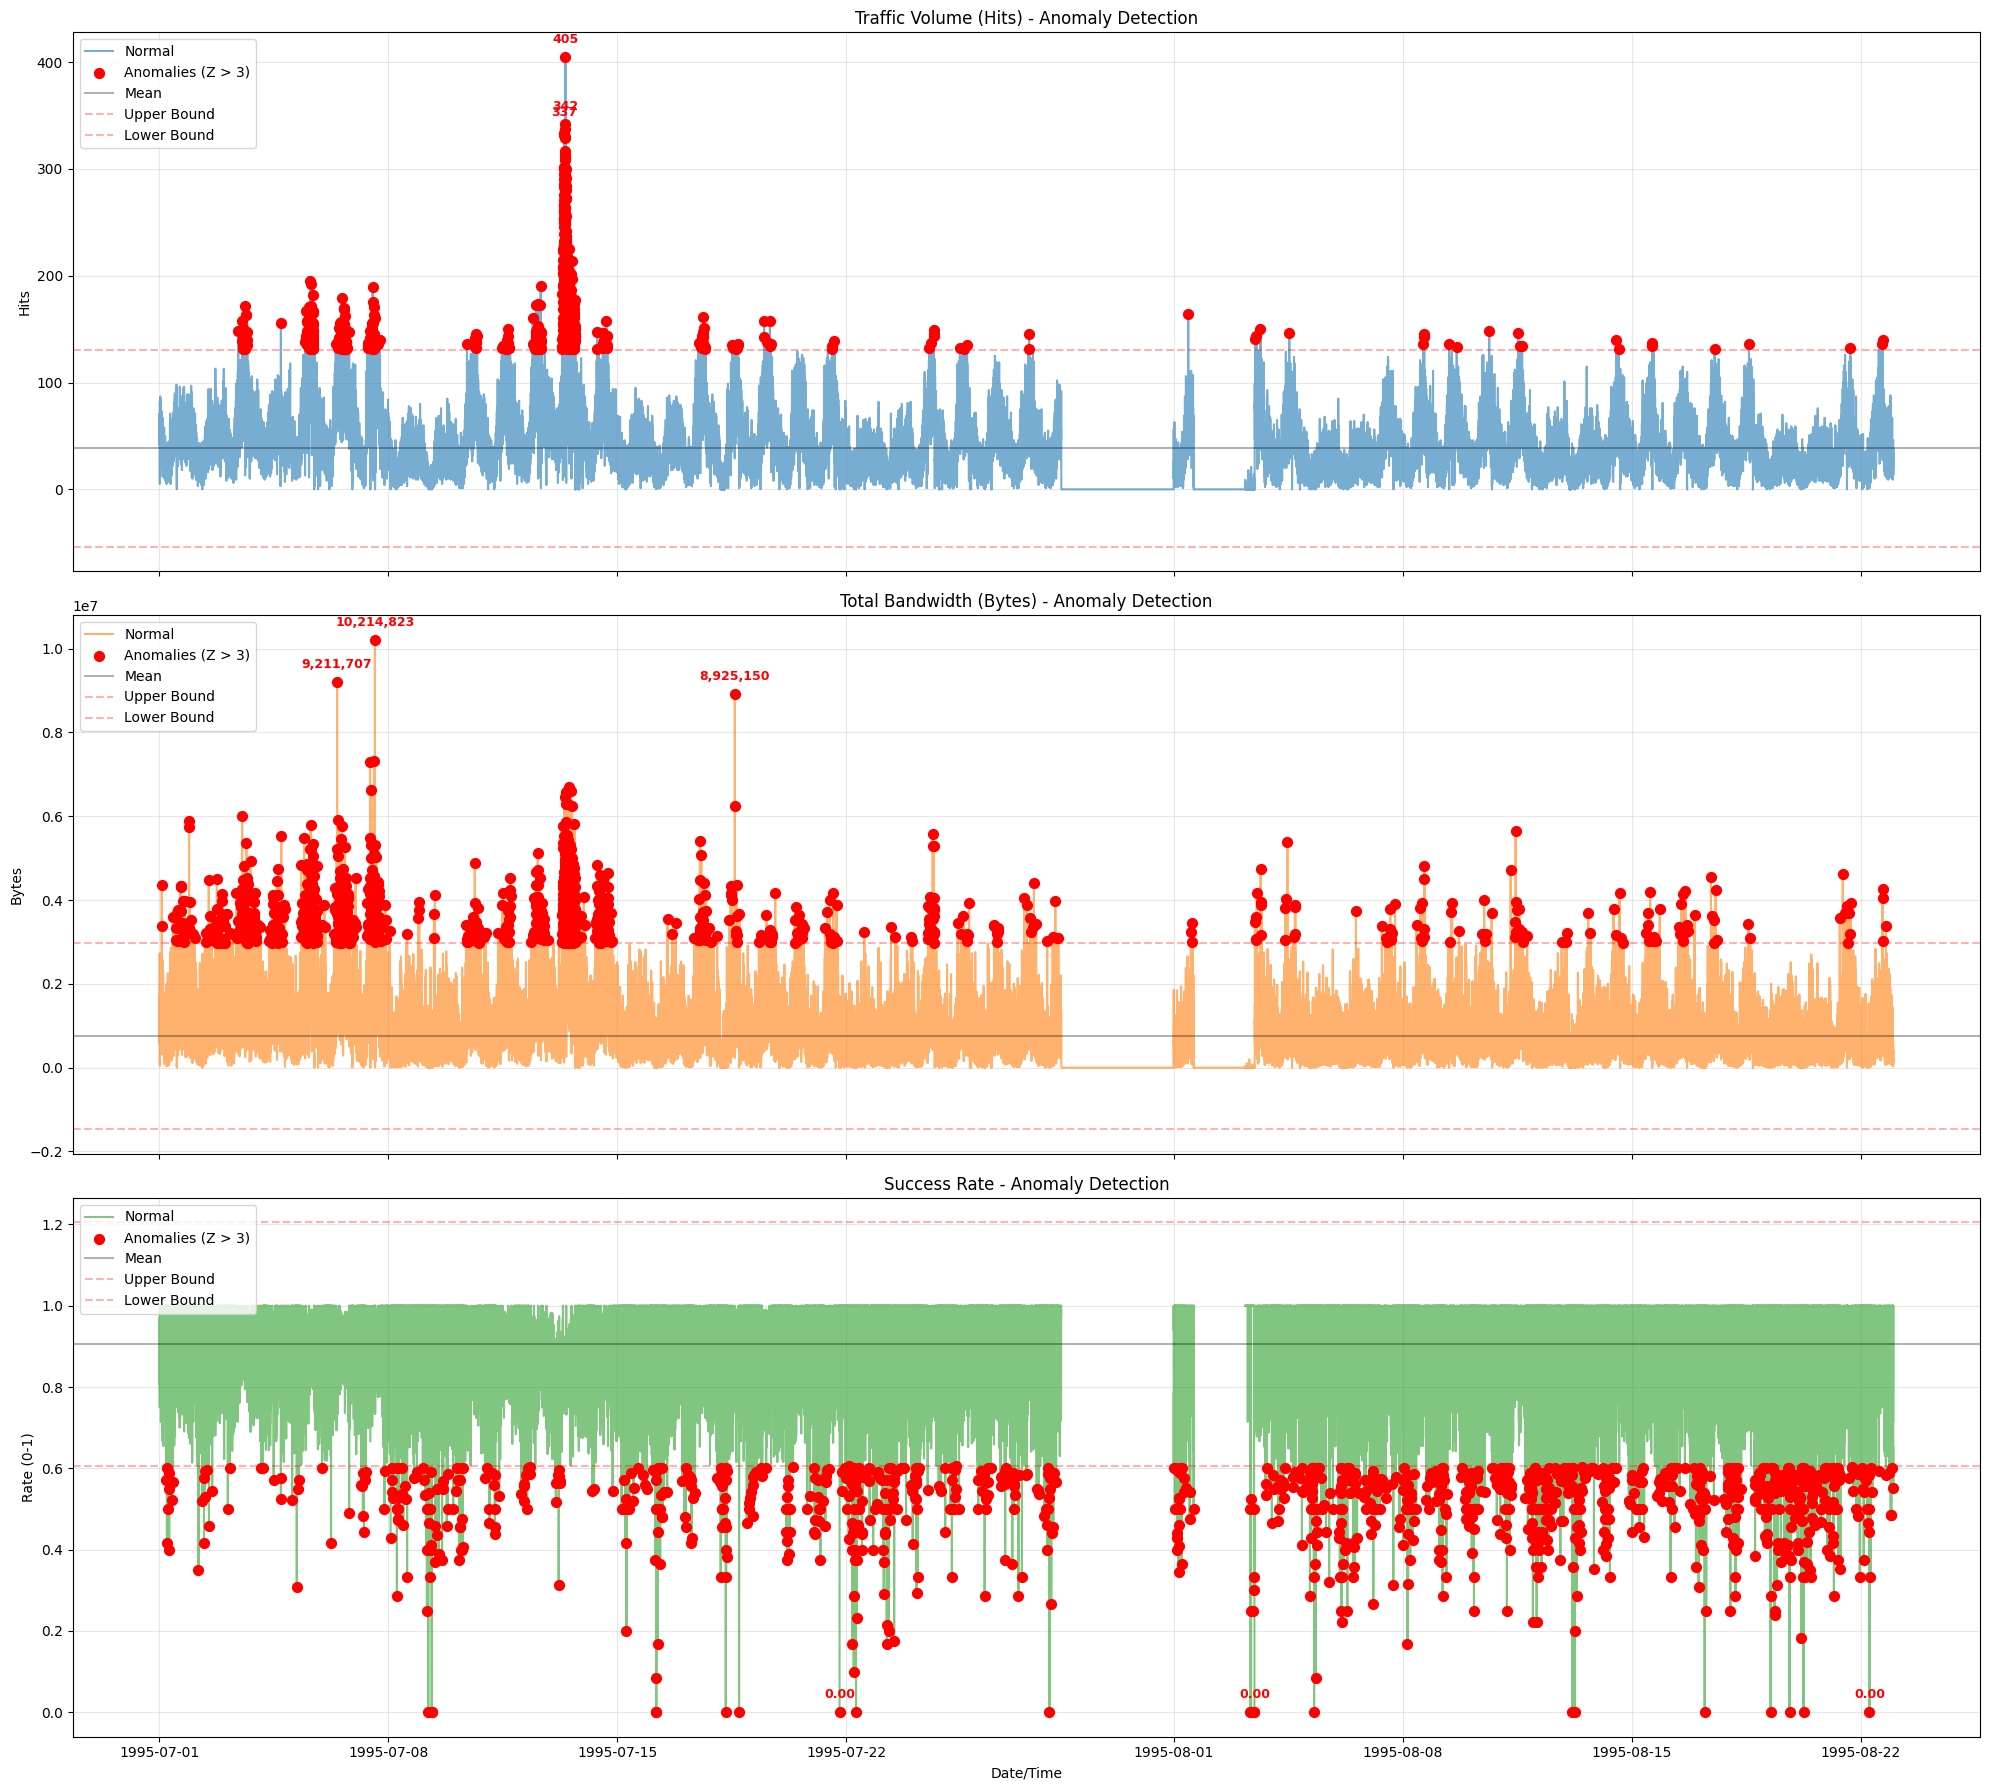

In [21]:
plot_anomaly_spikes(df, interval='1T', threshold_z=3)


Detecting Anomalies (Interval: 15T, Z-Threshold: 3)...


d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:528: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = df.resample(interval)
d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:538: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts_success = df[df['status_label'] == 'Success'].resample(interval).size()



Top Anomalies for Traffic Volume (Hits):


,Hits
time,
1995-07-13 09:00:00,"4,212"
1995-07-13 09:45:00,"4,167"
1995-07-13 09:30:00,"3,535"
1995-07-13 08:30:00,"3,480"
1995-07-13 10:00:00,"3,248"



Top Anomalies for Total Bandwidth (Bytes):


,Bytes
time,
1995-07-13 10:00:00,"59,636,961"
1995-07-13 09:00:00,"58,404,018"
1995-07-13 11:45:00,"56,678,862"
1995-07-13 11:00:00,"55,312,813"
1995-07-13 09:45:00,"55,207,320"



Top Anomalies for Success Rate:


,Rate (0-1)
time,
1995-08-03 11:00:00,0.5000
1995-08-06 03:00:00,0.6045
1995-08-06 02:45:00,0.6898
1995-08-07 02:15:00,0.6976
1995-08-03 08:45:00,0.6981


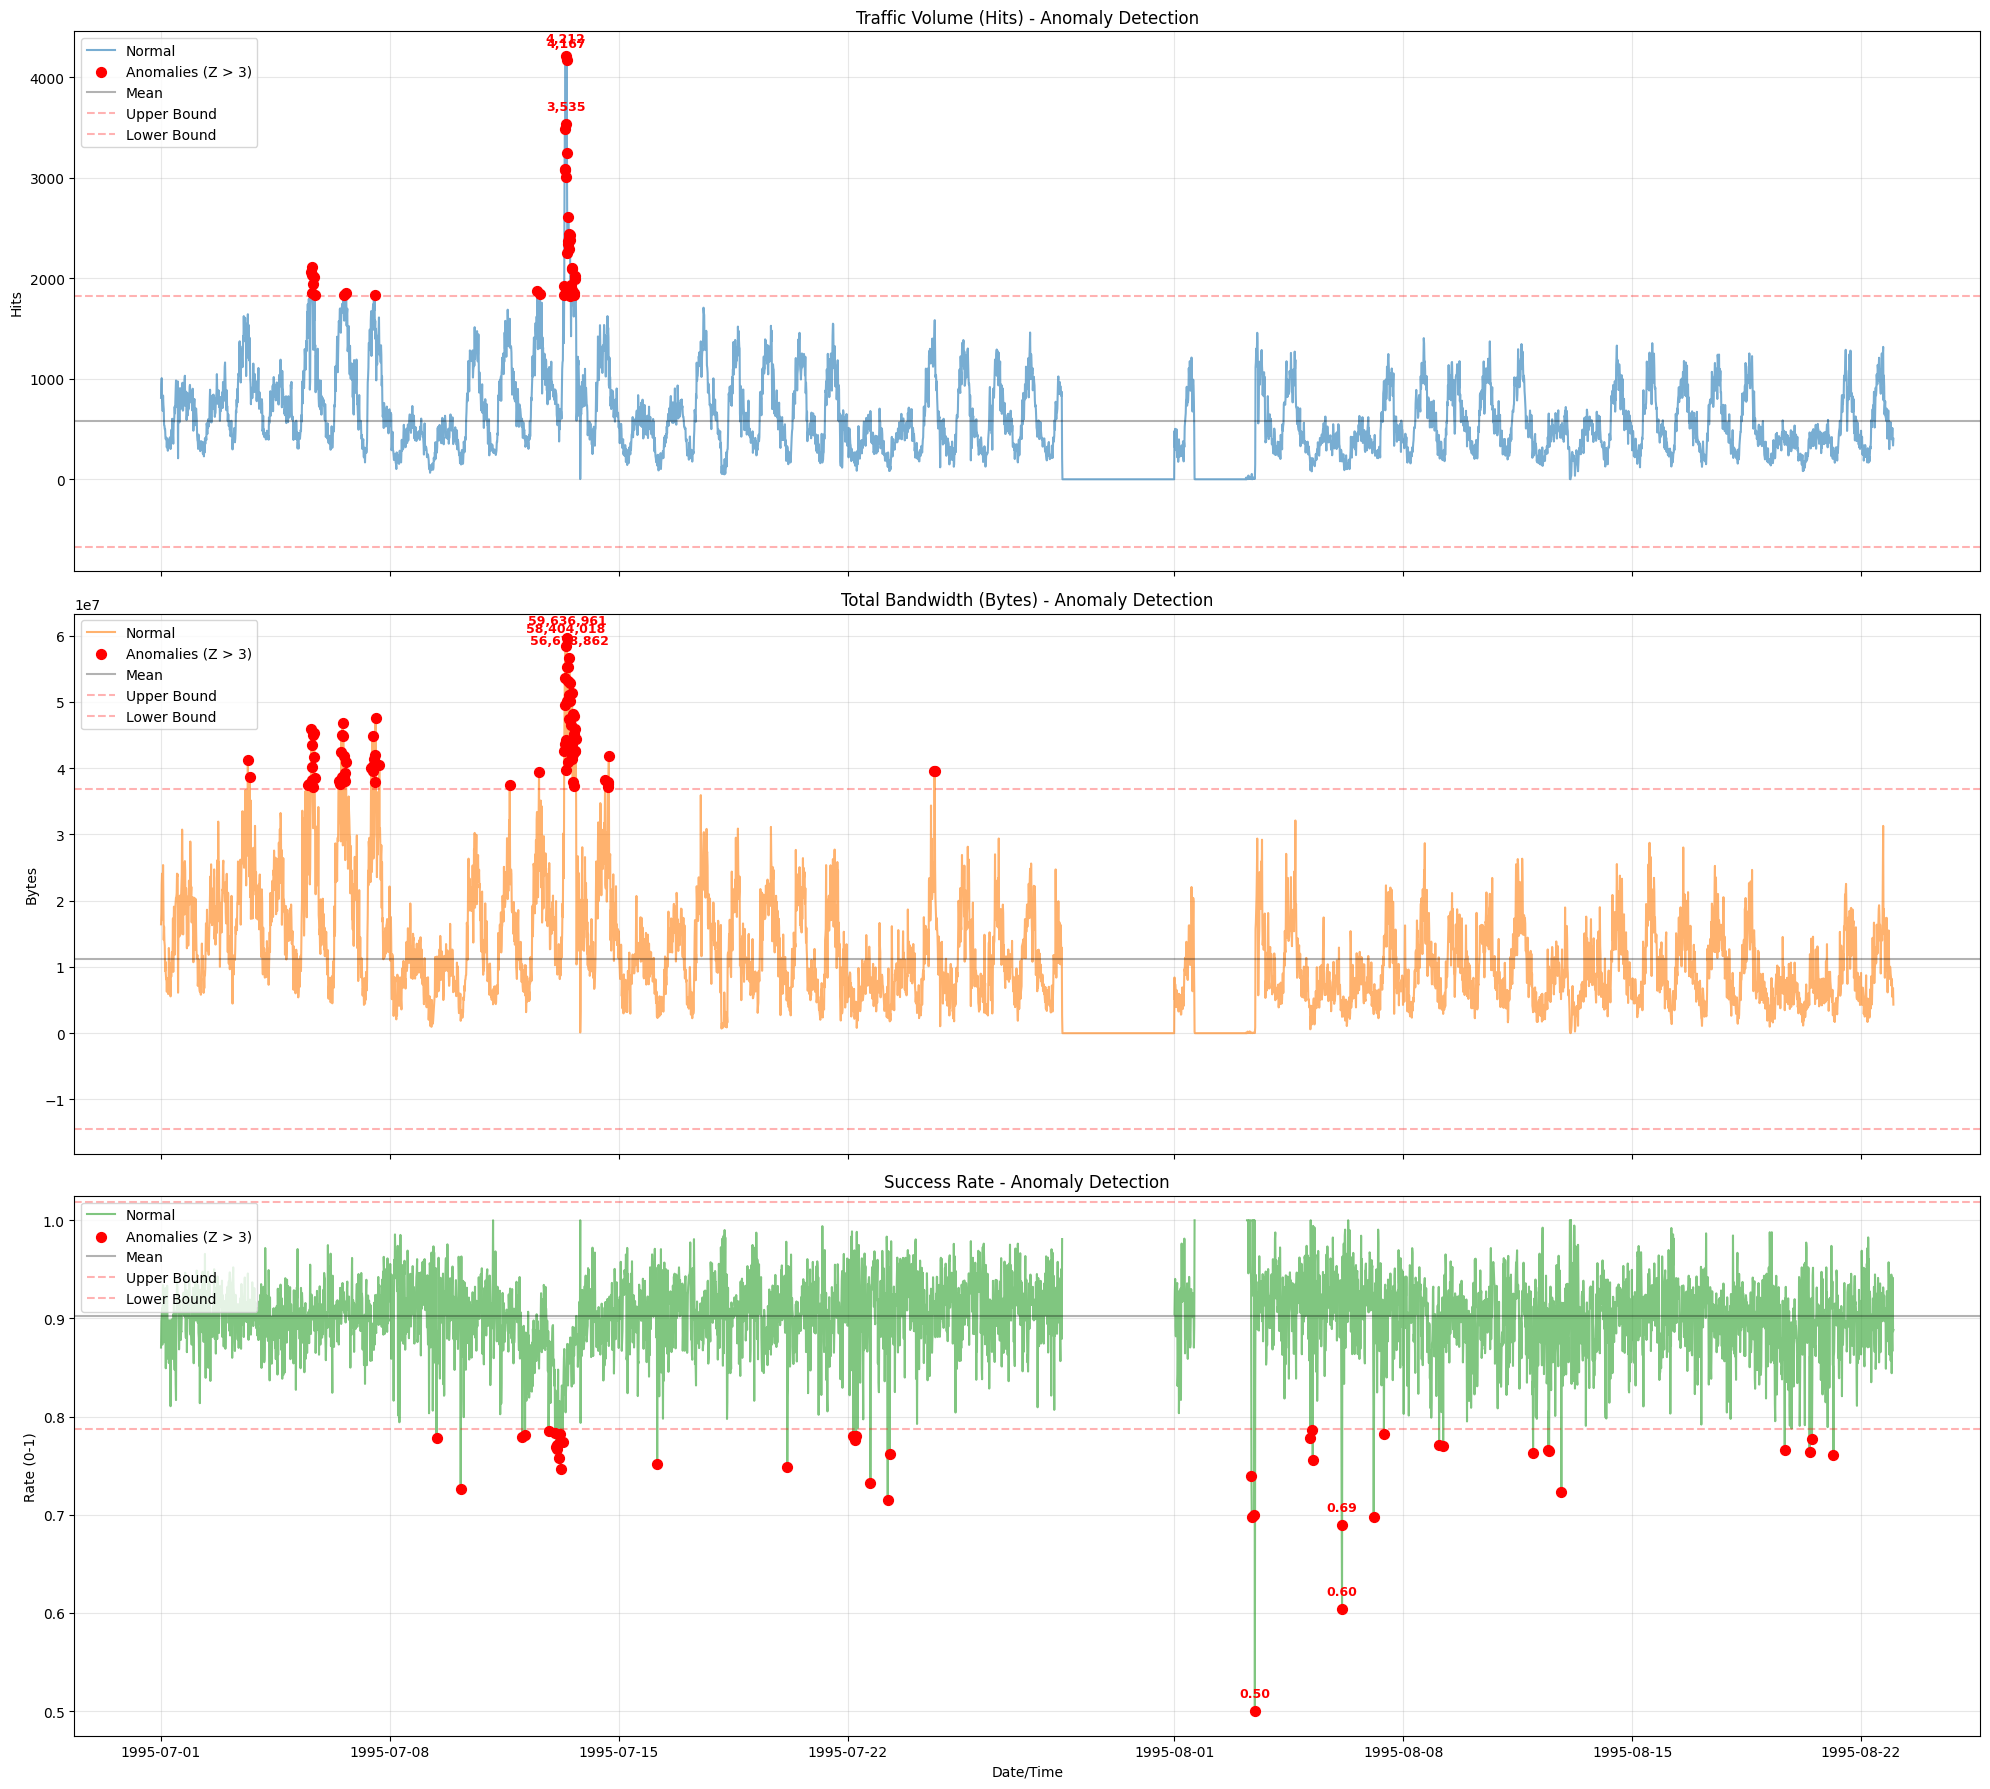

In [22]:
plot_anomaly_spikes(df, interval='15T', threshold_z=3)

Detecting Anomalies (Interval: 1H, Z-Threshold: 3)...


d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:528: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampler = df.resample(interval)
d:\Study\Education\Projects\DataFlow\DataFlow_2026\FomoKaguya2026\eda\plot_utils.py:538: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_success = df[df['status_label'] == 'Success'].resample(interval).size()



Top Anomalies for Traffic Volume (Hits):


,Hits
time,
1995-07-13 09:00:00,"14,926"
1995-07-13 08:00:00,"11,567"
1995-07-13 10:00:00,"10,214"
1995-07-13 11:00:00,"9,748"
1995-07-13 12:00:00,"8,533"



Top Anomalies for Total Bandwidth (Bytes):


,Bytes
time,
1995-07-13 11:00:00,"210,387,333"
1995-07-13 10:00:00,"203,867,859"
1995-07-13 09:00:00,"197,622,302"
1995-07-13 12:00:00,"192,092,148"
1995-07-13 08:00:00,"189,356,873"



Top Anomalies for Success Rate:


,Rate (0-1)
time,
1995-07-13 02:00:00,0.7744
1995-07-13 05:00:00,0.7826
1995-08-03 08:00:00,0.7895
1995-07-13 04:00:00,0.7929
1995-08-03 07:00:00,1.0000


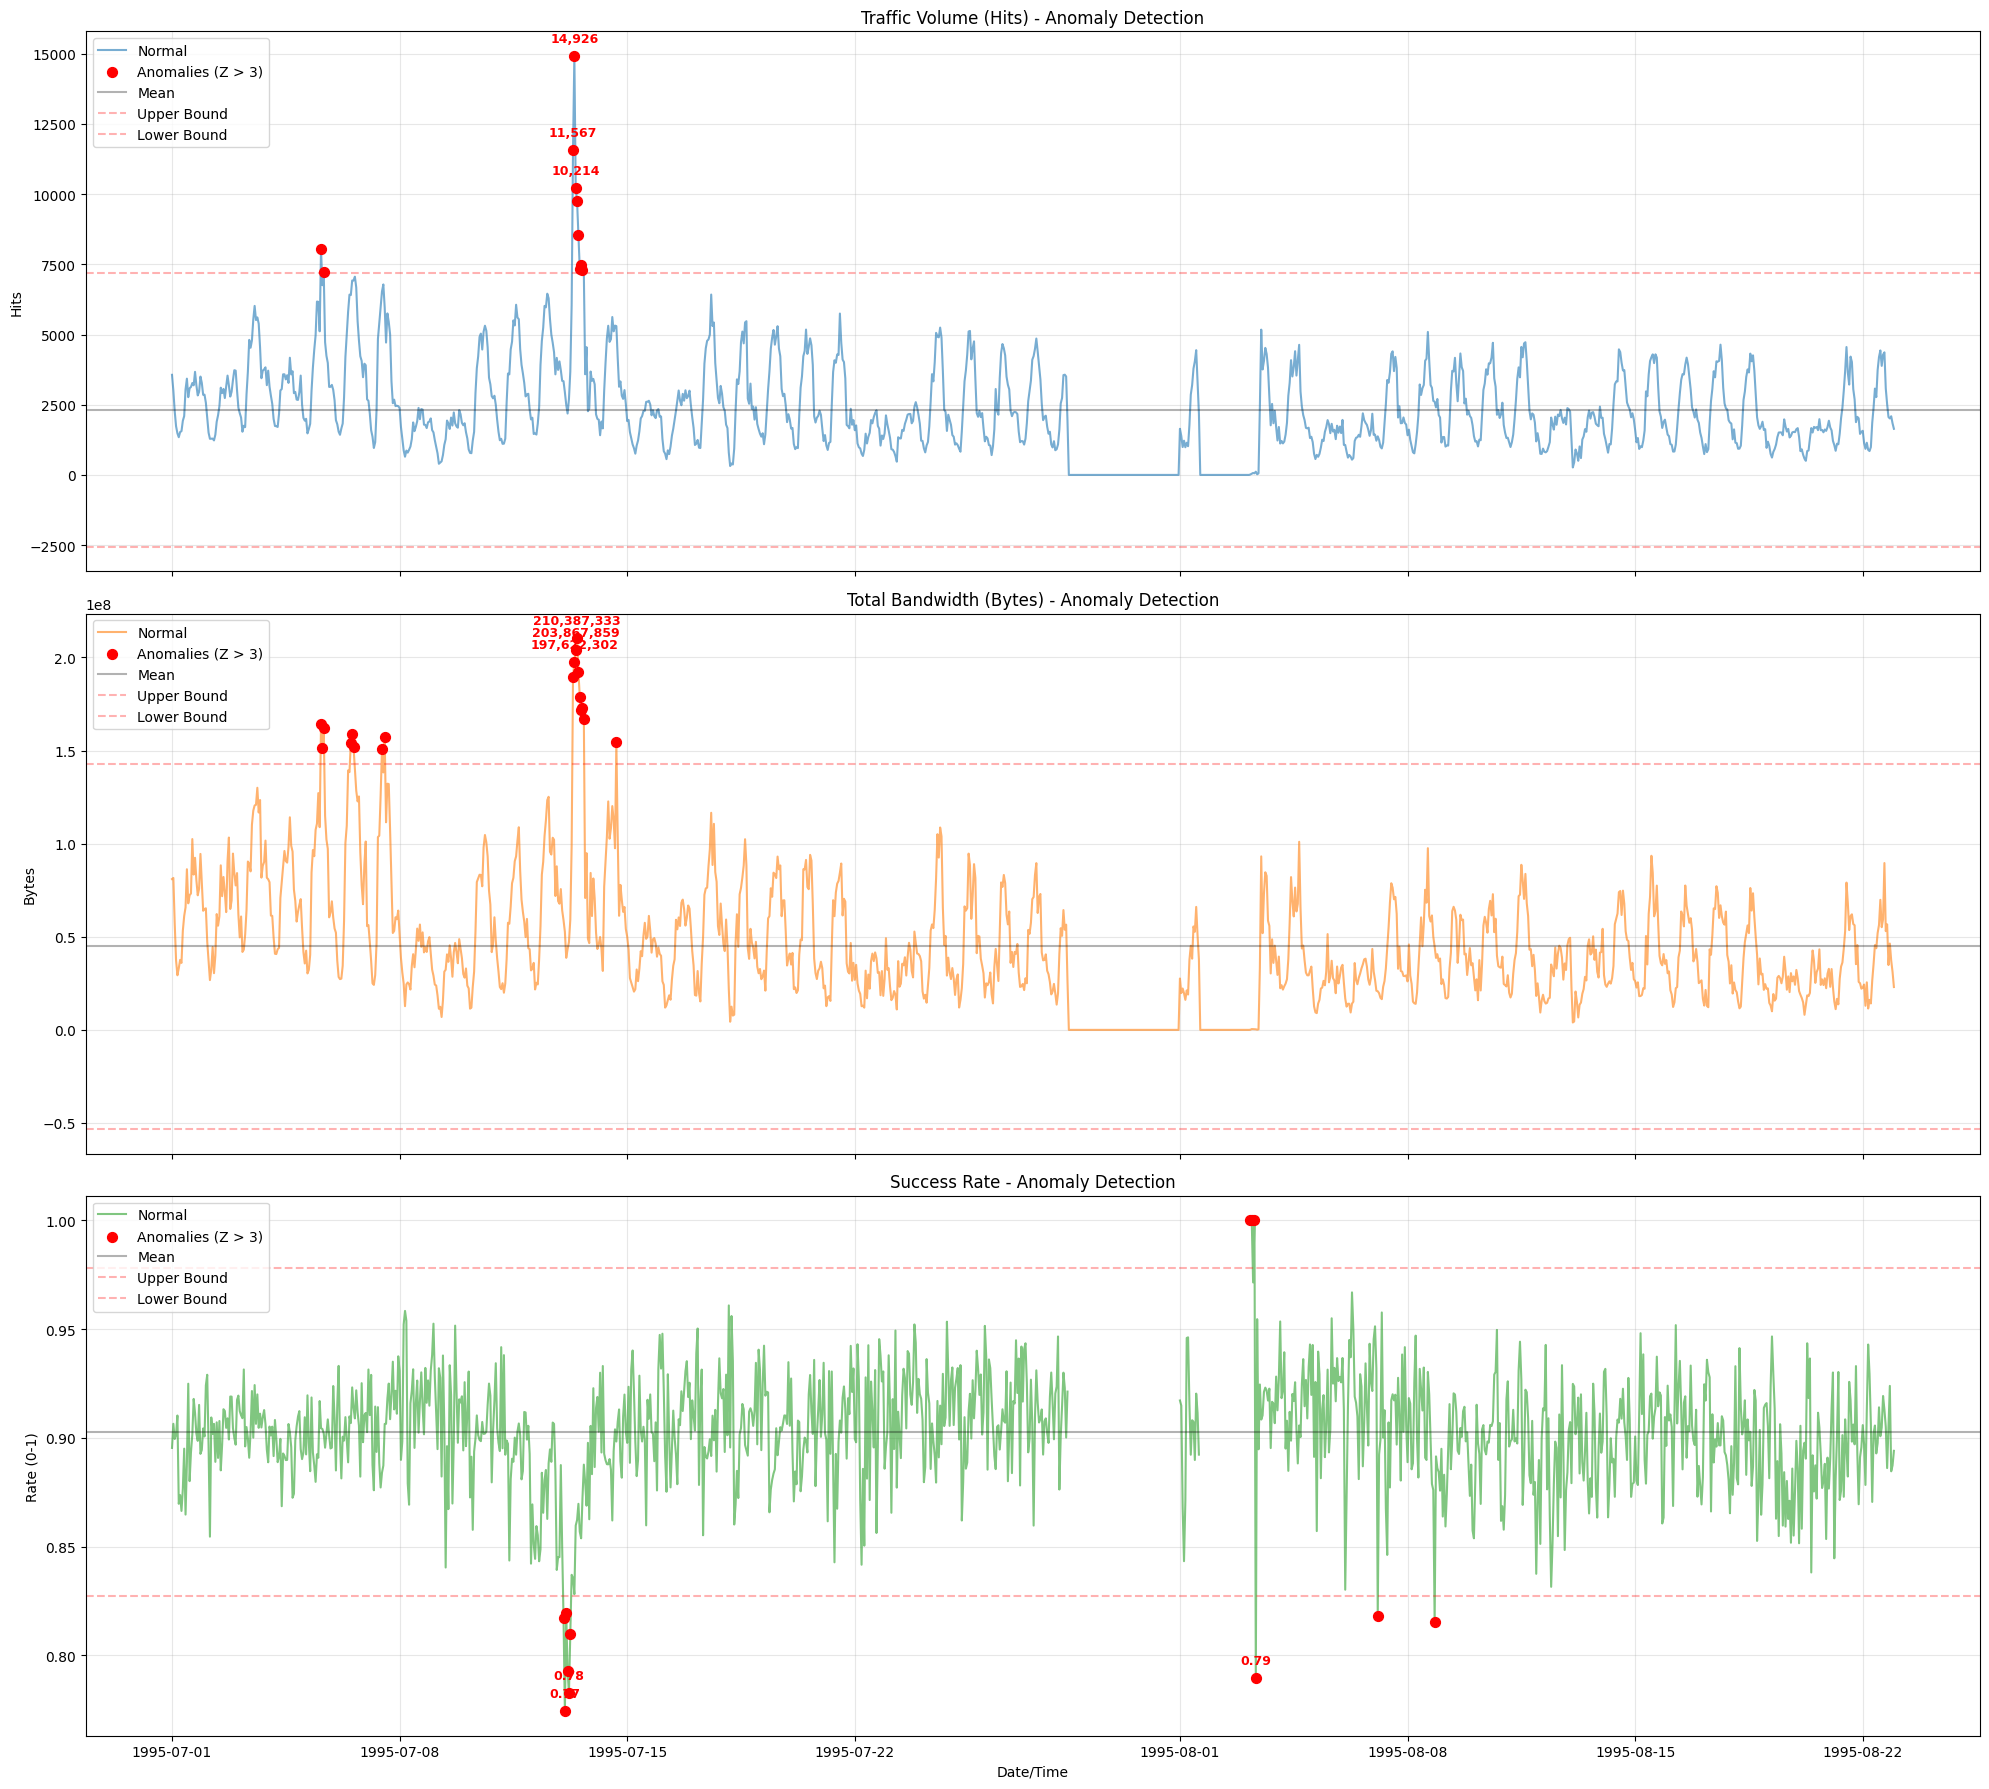

In [23]:
plot_anomaly_spikes(df, interval='1H', threshold_z=3)

Calculating Status Evolution (interval=1D)...


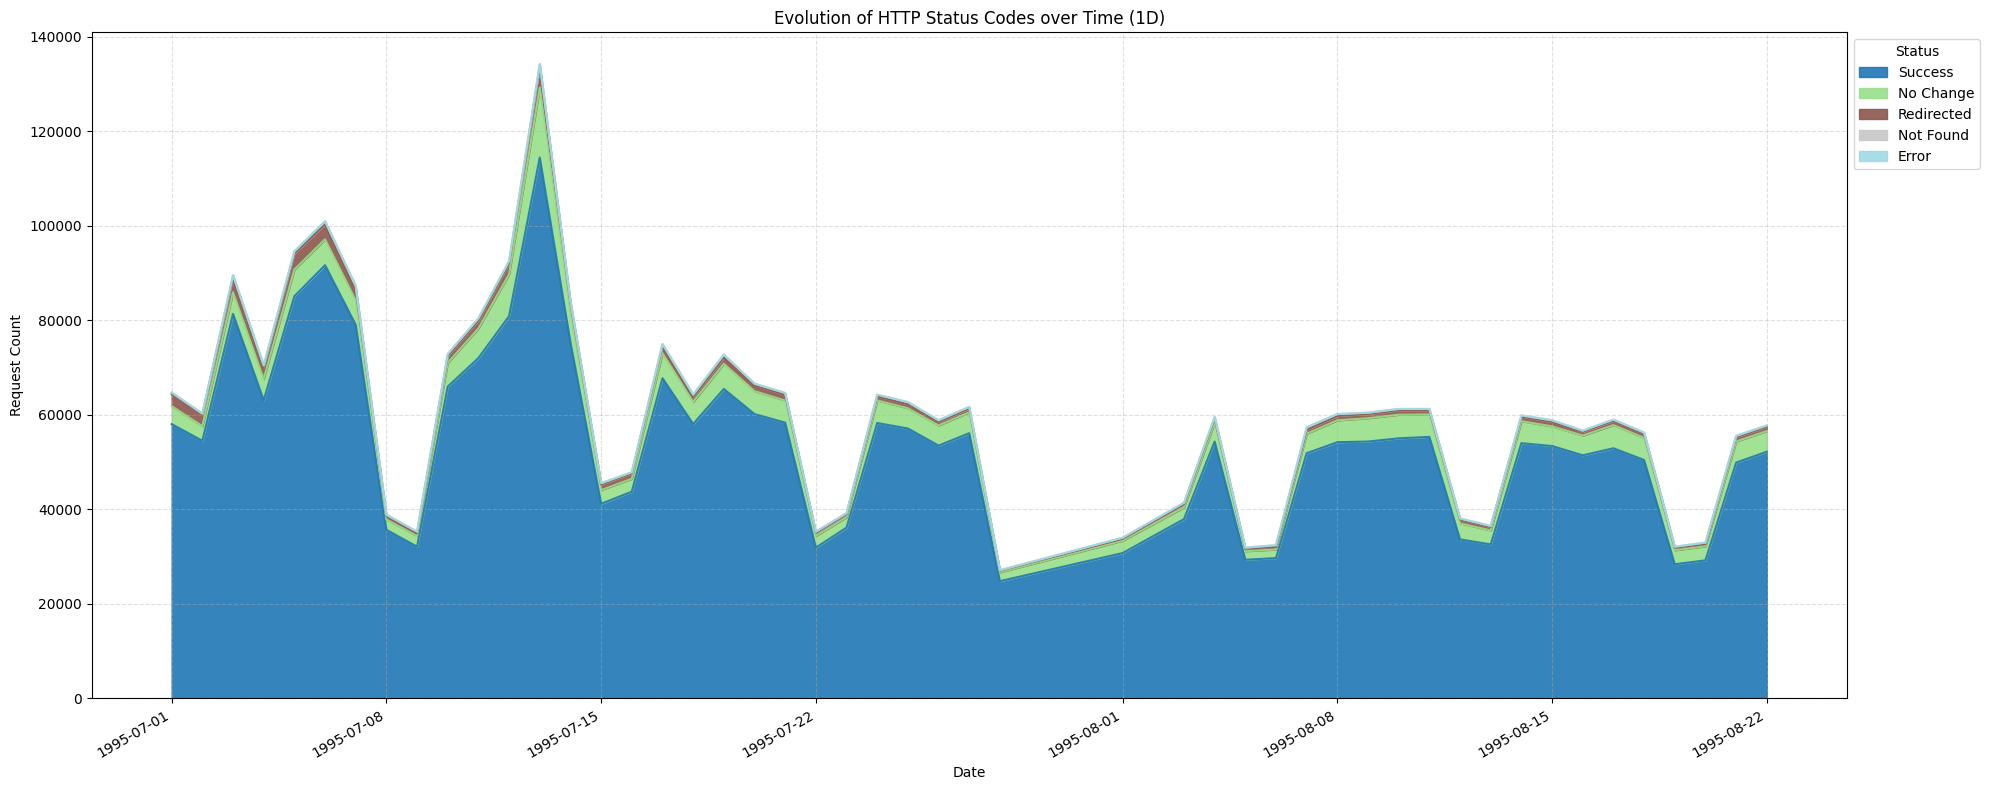

In [24]:
plot_status_evolution(df)


Analyzing Response Size Distribution...


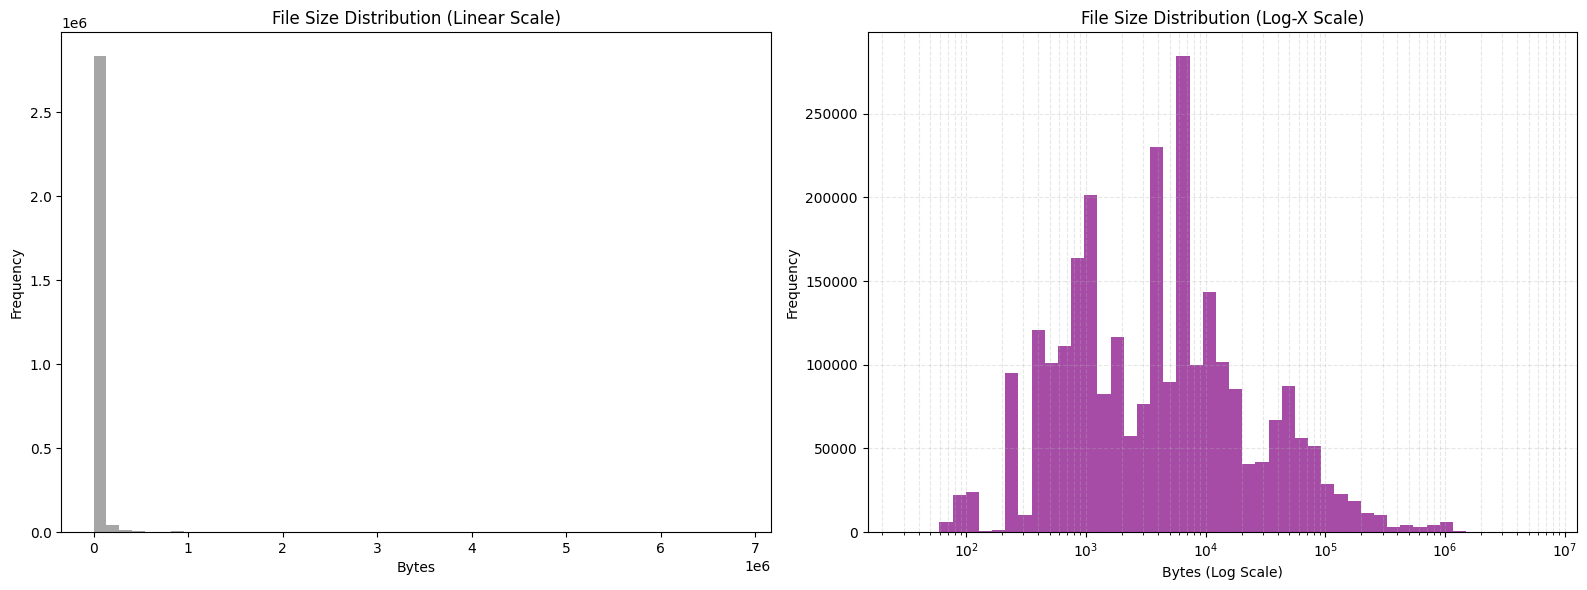

Zero-byte responses: 223474 (7.6%)
Small files (<1KB): 882297 (30.1%)
Large files (>1MB): 3885 (0.1%)


In [25]:
plot_size_distribution(df)


### Hypothesis

#### 1. Traffic follows a cycle with pattern

already Up, follows a pattern low in 0->7h, peak at 9-17h

#### 2. High traffic IP occurs at specific time in a day/ month

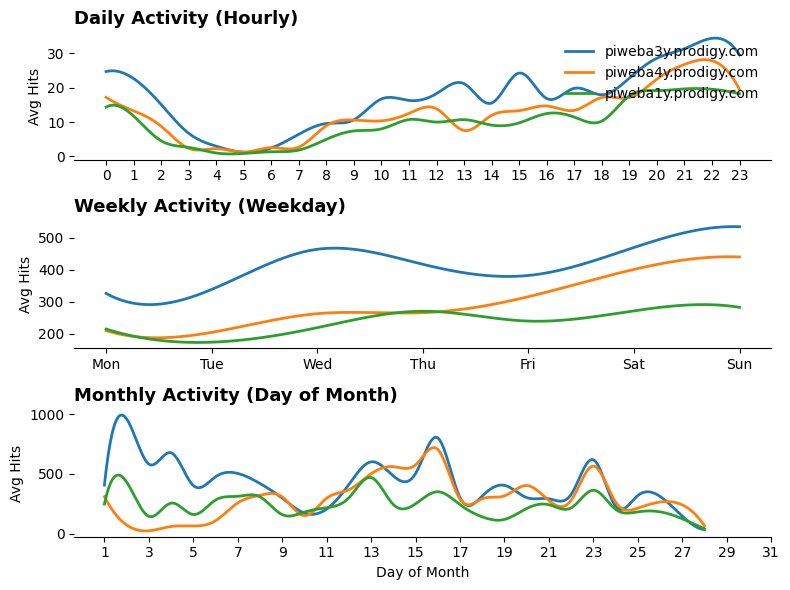

In [31]:
df['time'] = df.index

top_3_ips = df['ip'].value_counts().head(3).index
df_top_3 = df[df['ip'].isin(top_3_ips)]
df['day_of_week'] = df['time'].dt.dayofweek
df['day_of_month'] = df['time'].dt.day

unique_dates = pd.to_datetime(df['time'].dt.date.unique())
num_days = len(unique_dates)
days_counts = unique_dates.dayofweek.value_counts()
dom_counts = unique_dates.day.value_counts()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

def plot_smooth(ax, x, y, label=None):
    x_new = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=3)(x_new)
    ax.plot(x_new, np.maximum(y_smooth, 0), label=label, linewidth=2)

ip_h = df_top_3.groupby(['ip', 'hour']).size().unstack(fill_value=0) / num_days
for ip in top_3_ips:
    plot_smooth(ax1, ip_h.columns.values, ip_h.loc[ip], label=ip)

ip_d = df_top_3.groupby(['ip', 'day_of_week']).size().unstack(fill_value=0).div(days_counts, axis=1)
for ip in top_3_ips:
    plot_smooth(ax2, ip_d.columns.values, ip_d.loc[ip])

ip_m = df_top_3.groupby(['ip', 'day_of_month']).size().unstack(fill_value=0).div(dom_counts, axis=1)
for ip in top_3_ips:
    plot_smooth(ax3, ip_m.columns.values, ip_m.loc[ip])

titles = ['Daily Activity (Hourly)', 'Weekly Activity (Weekday)', 'Monthly Activity (Day of Month)']
for ax, t in zip([ax1, ax2, ax3], titles):
    ax.set_title(t, loc='left', fontweight='bold', fontsize=13)
    ax.set_ylabel('Avg Hits')
    ax.set_facecolor('white')
    ax.grid(False)
    for s in ['top','right','left']: ax.spines[s].set_visible(False)

ax1.set_xticks(range(24))
ax1.legend(frameon=False, loc='upper right')
ax2.set_xticks(range(7))
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax3.set_xticks(range(1, 32, 2))
ax3.set_xlabel('Day of Month')

plt.tight_layout()
plt.show()

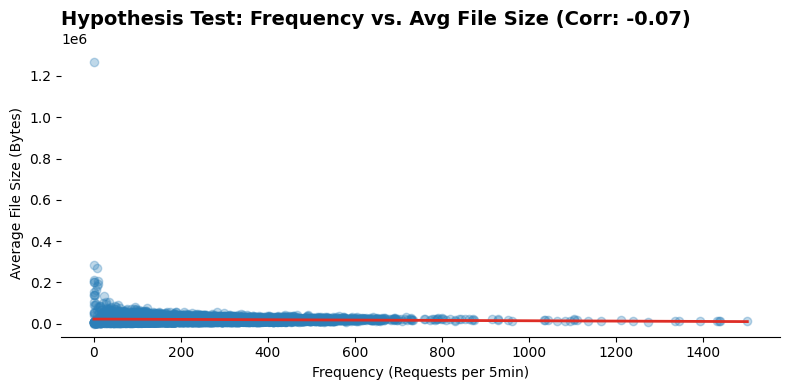

In [32]:
agg_relation = df.set_index('time').resample('5min').agg({
    'ip': 'count', 
    'size': 'mean'
}).rename(columns={'ip': 'frequency', 'size': 'avg_file_size'})

correlation = agg_relation.corr().iloc[0, 1]

plt.figure(figsize=(8, 4))
sns.regplot(
    data=agg_relation, 
    x='frequency', 
    y='avg_file_size', 
    scatter_kws={'alpha': 0.3, 'color': '#2c7fb8'}, 
    line_kws={'color': '#de2d26', 'linewidth': 2}
)

plt.title(f'Hypothesis Test: Frequency vs. Avg File Size (Corr: {correlation:.2f})', 
          loc='left', fontweight='bold', fontsize=14)
plt.xlabel('Frequency (Requests per 5min)')
plt.ylabel('Average File Size (Bytes)')

ax = plt.gca()
ax.set_facecolor('white')
ax.grid(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

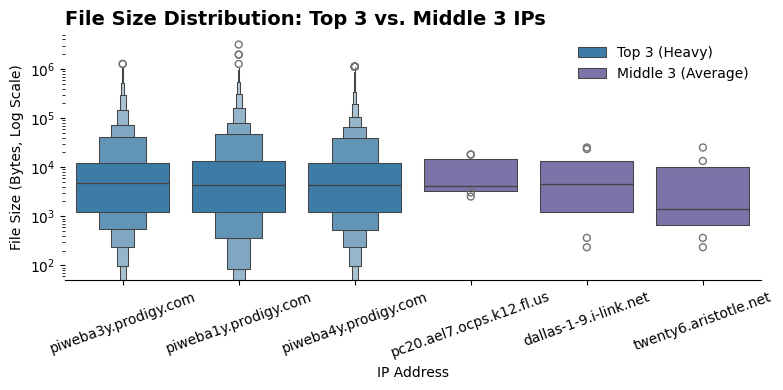

In [34]:
# Count occurrences per IP (only positive sizes)
counts = df.loc[df['size'] > 0, 'ip'].value_counts()

# Identify top 3 (heavy) and middle 3 (average) IPs
mid_idx = len(counts) // 2
top_3 = counts.head(3).index.tolist()
middle_3 = counts.iloc[mid_idx - 1: mid_idx + 2].index.tolist()

# Subset data for comparison
df_compare = (
    df[df['ip'].isin(top_3 + middle_3)]
    .copy()
    .reset_index(drop=True)   # IMPORTANT for seaborn boxenplot
)

# Assign groups
df_compare['group'] = df_compare['ip'].map(
    lambda ip: 'Top 3 (Heavy)' if ip in top_3 else 'Middle 3 (Average)'
)

# Plot
plt.figure(figsize=(8, 4))
sns.boxenplot(
    data=df_compare,
    x='ip',
    y='size',
    hue='group',
    palette={
        'Top 3 (Heavy)': '#2c7fb8',
        'Middle 3 (Average)': '#756bb1'
    }
)

plt.yscale('log')
plt.title(
    'File Size Distribution: Top 3 vs. Middle 3 IPs',
    loc='left', fontweight='bold', fontsize=14
)
plt.xlabel('IP Address')
plt.ylabel('File Size (Bytes, Log Scale)')
plt.legend(frameon=False, title='')

# Aesthetic cleanup
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [35]:
df.columns

Index(['ip', 'identd', 'user', 'request', 'status', 'size', 'resource',
       'protocol', 'utc', 'status_label', 'file_type', 'hour', 'time',
       'day_of_week', 'day_of_month'],
      dtype='object')